# [**Graphiques de dépendance partielle et d'espérance conditionnelle individuelle**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/4_inspection/plot_partial_dependence.ipynb)<br/>([*Partial Dependence and Individual Conditional Expectation Plots*](https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html))

Les diagrammes de dépendance partielle montrent la dépendance entre la fonction cible [2] et un ensemble de caractéristiques d'intérêt, en marginalisant les valeurs de toutes les autres caractéristiques (les caractéristiques complémentaires). En raison des limites de la perception humaine, la taille de l'ensemble des caractéristiques d'intérêt doit être petite (généralement, une ou deux), elles sont donc généralement choisies parmi les caractéristiques les plus importantes.

De même, un graphique d'espérance conditionnelle individuelle (ICE) [3] montre la dépendance entre la fonction cible et une caractéristique d'intérêt. Cependant, contrairement aux diagrammes de dépendance partielle, qui montrent l'effet moyen des caractéristiques d'intérêt, les diagrammes ICE visualisent la dépendance de la prédiction sur une caractéristique pour chaque échantillon séparément, avec une ligne par [échantillon](https://scikit-learn.org/stable/glossary.html#term-sample). Une seule caractéristique d'intérêt est prise en charge pour les tracés ICE.

Cet exemple montre comment obtenir une dépendance partielle et des tracés ICE à partir d'un [`MLPRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) et d'un [`HistGradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor) formés sur l'ensemble de données de logement en Californie. L'exemple est tiré de [1].

[1] T. Hastie, R. Tibshirani et J. Friedman, [“**Elements of Statistical Learning Ed. 2**](https://hastie.su.domains/Papers/ESLII.pdf)[”](https://drive.google.com/file/d/1wbK7Ii8bQliX7D3rKyGoR0-gxqJZ11iN/view?usp=share_link), Springer, 2009.

[2] Pour la classification, vous pouvez le considérer comme le score de régression avant la fonction de lien.

[3] Goldstein, A., Kapelner, A., Bleich, J., and Pitkin, E. [“**Peeking Inside the Black Box: Visualizing Statistical Learning With Plots of Individual Conditional Expectation**](https://arxiv.org/abs/1309.6392)[”](https://drive.google.com/file/d/1zGXt3Wk54sYV4fJaj4lhuotHDlQ9CLsN/view?usp=share_link). Journal of Computational and Graphical Statistics, 24(1): 44-65, 2015

# Prétraitement des données sur le logement en Californie

Centrer la cible pour éviter le biais d'initialisation du gradient boosting : le gradient boosting avec la méthode "récursion" ne tient pas compte de l'estimateur initial (ici la cible moyenne, par défaut).

In [1]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target

y -= y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Dépendance partielle unidirectionnelle avec différents modèles

Dans cette section, nous allons calculer la dépendance partielle à 1 facteur avec deux modèles d'apprentissage automatique différents : (i) un perceptron multicouche et (ii) un gradient-boosting. Avec ces deux modèles, nous illustrons comment calculer et interpréter à la fois le diagramme de dépendance partielle (PDP) et l'espérance conditionnelle individuelle (ICE).

## Perceptron multicouche

Ajustons un [`MLPRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) et calculons des diagrammes de dépendance partielle à variable unique.

In [2]:
from time import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor

print("Training MLPRegressor...")
tic = time()
est = make_pipeline(
    QuantileTransformer(),
    MLPRegressor(
        hidden_layer_sizes=(30, 15),
        learning_rate_init=0.01,
        early_stopping=True,
        random_state=0,
    ),
)
est.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {est.score(X_test, y_test):.2f}")

Training MLPRegressor...
done in 4.711s
Test R2 score: 0.82


Nous avons configuré un pipeline pour mettre à l'échelle les caractéristiques numériques d'entrée et réglé la taille du réseau de neurones et le taux d'apprentissage pour obtenir un compromis raisonnable entre le temps d'apprentissage et les performances prédictives sur un ensemble de test.

Il est important de noter que cet ensemble de données tabulaires a des plages dynamiques très différentes pour ses caractéristiques. Les réseaux de neurones ont tendance à être très sensibles aux caractéristiques avec des échelles variables et oublier de prétraiter la caractéristique numérique conduirait à un modèle très médiocre.

Il serait possible d'obtenir des performances prédictives encore plus élevées avec un réseau de neurones plus important, mais l'apprentissage serait également beaucoup plus coûteux.

Notez qu'il est important de vérifier que le modèle est suffisamment précis sur un ensemble de test avant de tracer la dépendance partielle car il serait peu utile d'expliquer l'impact d'une caractéristique donnée sur la fonction de prédiction d'un modèle médiocre.

Nous tracerons la dépendance partielle, à la fois individuelle (ICE) et moyenne (PDP). Nous limitons à seulement 50 courbes ICE pour ne pas surcharger le diagramme.

Computing partial dependence plots...
done in 5.598s


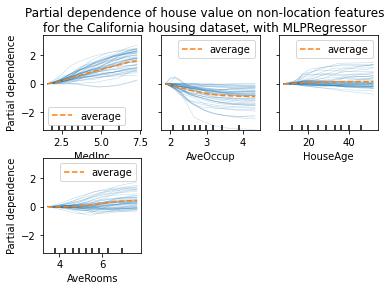

In [3]:
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "centered": True,
    "random_state": 0,
}

print("Computing partial dependence plots...")
tic = time()
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features=["MedInc", "AveOccup", "HouseAge", "AveRooms"],
    kind="both",
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    "Partial dependence of house value on non-location features\n"
    "for the California housing dataset, with MLPRegressor"
)
display.figure_.subplots_adjust(hspace=0.3)

## Amplification de gradient

Ajustons maintenant un [`HistGradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor) et calculons la dépendance partielle sur les mêmes caractéristiques.

In [4]:
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoostingRegressor...")
tic = time()
est = HistGradientBoostingRegressor(random_state=0)
est.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {est.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 1.337s
Test R2 score: 0.85


Ici, nous avons utilisé les hyperparamètres par défaut pour le modèle d'amplification de gradient sans aucun prétraitement, car les modèles arborescents sont naturellement robustes aux transformations monotones des caractéristiques numériques.

Notez que sur cet ensemble de données tabulaires, les Gradient Boosting Machines sont à la fois beaucoup plus rapides à entraîner et plus précises que les réseaux de neurones. Il est également beaucoup moins cher de régler leurs hyperparamètres (les valeurs par défaut ont tendance à bien fonctionner alors que ce n'est pas souvent le cas pour les réseaux de neurones).

Nous tracerons la dépendance partielle, à la fois individuelle (ICE) et moyenne (PDP). Nous limitons à seulement 50 courbes ICE pour ne pas surcharger la parcelle.

Computing partial dependence plots...
done in 2.885s


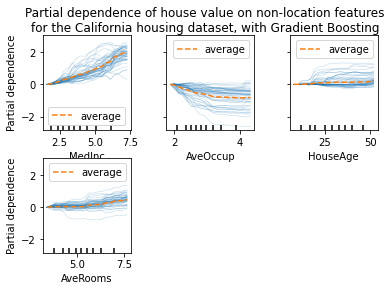

In [5]:
print("Computing partial dependence plots...")
tic = time()
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features=["MedInc", "AveOccup", "HouseAge", "AveRooms"],
    kind="both",
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    "Partial dependence of house value on non-location features\n"
    "for the California housing dataset, with Gradient Boosting"
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

## Analyse des diagrammes

Nous pouvons clairement voir sur les PDP (ligne orange en pointillés) que le prix médian des maisons montre une relation linéaire avec le revenu médian (en haut à gauche) et que le prix des maisons baisse lorsque le nombre moyen d'occupants par ménage augmente (en haut au milieu). Le graphique en haut à droite montre que l'âge du logement dans un quartier n'a pas une forte influence sur le prix (médian) du logement ; il en va de même pour le nombre moyen de pièces par ménage.

Les courbes ICE (lignes bleu clair) complètent l'analyse : on peut voir qu'il existe quelques exceptions (qui sont mieux mises en évidence avec l'option `centered=True`), où le prix du logement reste constant par rapport aux variations du revenu médian et des occupants moyens. D'autre part, alors que l'âge du logement (en haut à droite) n'a pas une forte influence sur le prix médian du logement en moyenne, il semble y avoir un certain nombre d'exceptions où le prix du logement augmente entre 15 et 25 ans. Des exceptions similaires peuvent être observées pour le nombre moyen de chambres (en bas à gauche). Par conséquent, les diagrammes ICE montrent certains effets individuels qui sont atténués en prenant les moyennes.

Dans tous les tracés, les graduations sur l'axe des x représentent les déciles des valeurs des caractéristiques dans les données d'entraînement.

Nous observons également que le [`MLPRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) a des prédictions beaucoup plus fluides que [`HistGradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor).

Cependant, il convient de noter que nous créons des échantillons synthétiques potentiels sans signification si les caractéristiques sont corrélées.

# Graphiques d'interaction 2D

Les PDP avec deux caractéristiques d'intérêt nous permettent de visualiser les interactions entre eux. Cependant, les ICE ne peuvent pas être tracés de manière simple et donc interprétés. Une autre considération est liée à la performance pour calculer les PDP. Avec l'algorithme basé sur l'arbre, lorsque seuls les PDP sont demandés, ils peuvent être calculés de manière efficace en utilisant la méthode de `'récursion'`.

Computing partial dependence plots...
done in 1.850s


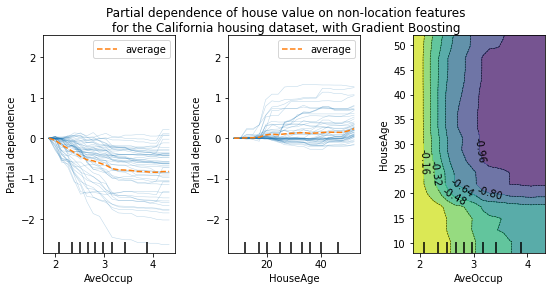

In [6]:
import matplotlib.pyplot as plt

print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, figsize=(9, 4))

# Note that we could have called the method `from_estimator` three times and
# provide one feature, one kind of plot, and one axis for each call.
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features=["AveOccup", "HouseAge", ("AveOccup", "HouseAge")],
    kind=["both", "both", "average"],
    ax=ax,
    **common_params,
)

print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    "Partial dependence of house value on non-location features\n"
    "for the California housing dataset, with Gradient Boosting"
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

Le diagramme de dépendance partielle à deux facteurs montre la dépendance du prix médian des maisons aux valeurs conjointes de l'âge des maisons et des occupants moyens par ménage. On voit bien une interaction entre les deux caractéristiques : pour une occupation moyenne supérieure à deux, le prix du logement est quasiment indépendant de l'âge du logement, alors que pour des valeurs inférieures à deux il y a une forte dépendance à l'âge.

# Graphiques d'interaction 3D

Faisons le même graphique de dépendance partielle pour l'interaction de 2 caractéristiques, cette fois en 3 dimensions.

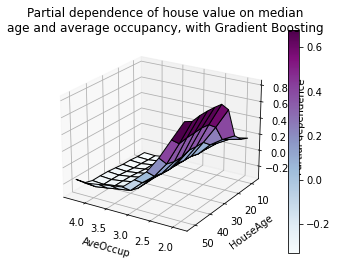

In [7]:
import numpy as np

# unused but required import for doing 3d projections with matplotlib < 3.2
# import mpl_toolkits.mplot3d  # noqa: F401

from sklearn.inspection import partial_dependence

fig = plt.figure()

features = ("AveOccup", "HouseAge")
pdp = partial_dependence(
    est, X_train, features=features, kind="average", grid_resolution=10
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of house value on median\n"
    "age and average occupancy, with Gradient Boosting"
)
plt.subplots_adjust(top=0.9)
plt.show()